In [121]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
# root_path = 'gdrive/My Drive/bio_film'
root_path = 'gdrive/My Drive/UNET/'
os.chdir(root_path)

In [3]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

## Seeding 
seed = 2022
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [4]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [5]:
image_size = 128
train_path = "train"
val_path = "test"
epochs = 10
batch_size =9

## Training Ids
train_ids = next(os.walk(train_path))[1]
valid_ids = next(os.walk(val_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids#[val_data_size:]

In [6]:
len(train_ids)
len(valid_ids)

10

In [7]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(9, 128, 128, 3) (9, 128, 128, 1)


(9, 128, 128, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


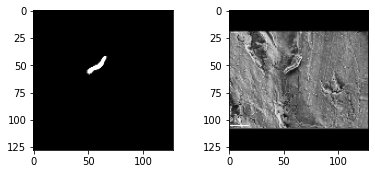

In [8]:
from re import I
x, y = gen.__getitem__(0)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(2): 
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(np.reshape(x[i], (image_size, image_size,3)), cmap="gray")

print(x.shape)

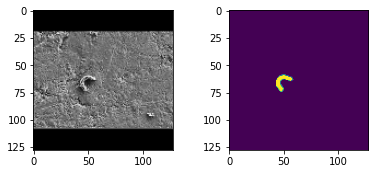

In [9]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="viridis")

In [35]:
initializer = tf.keras.initializers.GlorotUniform(seed=20)
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)
])
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(concat)
    c = BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(c)
    return c


In [62]:
from tensorflow.python import data

def UNet():
    f = [16,32, 64,128,256,512]
    inputs = keras.layers.Input((image_size, image_size, 3))
    

    
    p0 = inputs
    aug = data_augmentation(p0)
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1,c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid", kernel_initializer=initializer)(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [63]:
# !pip install keras_unet

In [64]:
# from keras_unet.models import custom_unet

# model1 = custom_unet(
#     input_shape=(128, 128, 3),
#     use_batch_norm=True,
#     num_classes=1,
#     filters=64,
#     dropout=0.2,
#     output_activation='sigmoid')

In [65]:
# model1.summary()


In [66]:

model = UNet()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_77 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_76[0][0]']              
                                )                                                           

In [67]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = max(len(valid_ids)//batch_size,1)

print(train_steps)


early_stopping_callback = EarlyStopping(monitor='loss', patience=3)

hist = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,epochs=30, callbacks=[early_stopping_callback])

6
Epoch 1/40
6/6 [==============================] - 8s 1s/step - loss: 0.6908 - acc: 0.5975 - val_loss: 0.6928 - val_acc: 0.6005
Epoch 2/40
6/6 [==============================] - 3s 419ms/step - loss: 0.5390 - acc: 0.8639 - val_loss: 0.7035 - val_acc: 0.5586
Epoch 3/40
6/6 [==============================] - 3s 416ms/step - loss: 0.4858 - acc: 0.9362 - val_loss: 0.7233 - val_acc: 0.4282
Epoch 4/40
6/6 [==============================] - 2s 412ms/step - loss: 0.4520 - acc: 0.9704 - val_loss: 0.7212 - val_acc: 0.4581
Epoch 5/40
6/6 [==============================] - 3s 416ms/step - loss: 0.4268 - acc: 0.9783 - val_loss: 0.7235 - val_acc: 0.3823
Epoch 6/40
6/6 [==============================] - 3s 419ms/step - loss: 0.4064 - acc: 0.9771 - val_loss: 0.7104 - val_acc: 0.4152
Epoch 7/40
6/6 [==============================] - 2s 410ms/step - loss: 0.3862 - acc: 0.9822 - val_loss: 0.6899 - val_acc: 0.6088
Epoch 8/40
6/6 [==============================] - 3s 414ms/step - loss: 0.3681 - acc: 0.981

In [68]:
print(valid_gen.__len__())
print(valid_steps)

10
1


In [95]:
## Save the Weights
# model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(8)
# print(x,y)
result = model.predict(x)
result =result >0.4
# result = (1-result) >0

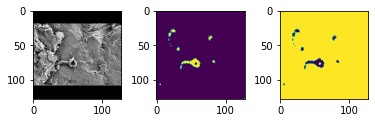

In [96]:

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i=0
ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(x[i], (image_size, image_size,3)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="viridis")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape((1-result[i])*255, (image_size, image_size)), cmap="viridis")